# MCMC parameter inference from single-molecule mRNA FISH data.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
import glob
import pickle
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd
import emcee

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages 
import corner

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/chemical_master_mRNA_FISH/'
tmpdir = '../../tmp/'

## $\LaTeX$ macros
$\newcommand{\kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{\kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{\rm}{r _m}$
$\newcommand{\gm}{\gamma _m}$
$\newcommand{\mm}{\left\langle m \right\rangle}$
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$

## Exploring the single-molecule mRNA FISH data from Jones et al. 2014.

In this notebook we will explore the use of the raw data from [Jones et al. 2014](http://science.sciencemag.org/content/346/6216/1533) on single molecule mRNA FISH data to make progress in determining parameters for the model.

First of all let's load the data.

In [2]:
# Read the data
df = pd.read_csv('../../data/mRNA_FISH/Jones_Brewster_2014.csv', index_col=0)

# Remove the different controls with no mRNA
df = df[(df.experiment != 'control') & 
        (df.experiment != 'Control') &
        (df.experiment != 'Ctrl')]
df.head()

area_cells      date experiment  spots_totals
0         321  20110920      5DL10             0
1         407  20110920      5DL10             4
2         337  20110920      5DL10             3
3         343  20110920      5DL10             2
4         320  20110920      5DL10             0

Now let's plot the raw data for the *lacUV5* promoter used in the project.

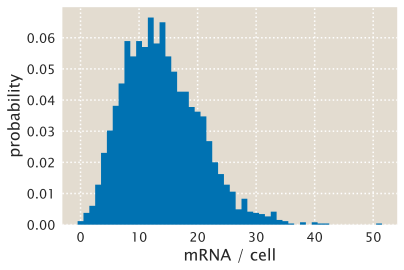

In [3]:
# Extract the lacUV5 data
dfUV5 = df[df.experiment == 'UV5']
# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=np.arange(0, dfUV5.spots_totals.max()),
             normed=1, histtype='stepfilled', align='left')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.savefig(figdir + 'lacUV5_smFISH_data.pdf')

## Two-state unregulated promoter model

Given the lack of agreement between the theory and the data at the protein level we will explore the possibility of using a two-state model for the unregulated promter where it transitions from an empty promoter to occupied by RNAP.

[Peccoud & Ycart](http://www.sciencedirect.com/science/article/pii/S0040580985710271) first derived the mRNA distribution for a two-state promoter from the chemical master equation. This distribution is given by
$$
\scriptstyle
P(m) = {\Gamma\left( {\kpon \over \gm} + m \right) \over
        \Gamma (m + 1) \Gamma\left( {\kpon + \kpoff \over \gm} + m \right)}
        {\Gamma\left( {\kpon + \kpoff \over \gm} \right) \over
         \Gamma\left( {\kpon \over \gm} \right) } 
         \left( {\rm \over \gm} \right)^m
         {}_1F_1 \left( {\kpon \over \gm} + m, {\kpoff + \kpon \over \gm} + m,
                       {-\rm \over \gm} \right),
$$
where ${}_1F_1$ is the confluent hypergeometric function.

Let's define a function that computes the log probability.

In [5]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_hyp= np.frompyfunc(lambda x, y, z: \
mpmath.ln(mpmath.hyp1f1(x, y, z, zeroprec=1000)), 3, 1)

def log_p_m_unreg(mRNA, kp_on, kp_off, gm, rm):
    '''
    Computes the log probability lnP(m) for an unregulated promoter, 
    i.e. the probability of having m mRNA.
    
    Parameters
    ----------
    mRNA : float.
        mRNA copy number at which evaluate the probability.        
    kp_on : float.
        rate of activation of the promoter in the chemical master equation
    kp_off : float.
        rate of deactivation of the promoter in the chemical master equation
    gm : float.
        1 / half-life time for the mRNA.
    rm : float.
        production rate of the mRNA
    
    Returns
    -------
    log probability lnP(m)
    '''
    # Convert the mRNA copy number to a  numpy array
    mRNA = np.array(mRNA)
    
    # Compute the probability
    lnp = scipy.special.gammaln(kp_on / gm + mRNA) \
    - scipy.special.gammaln(mRNA + 1) \
    - scipy.special.gammaln((kp_off + kp_on) / gm + mRNA) \
    + scipy.special.gammaln((kp_off + kp_on) / gm) \
    - scipy.special.gammaln(kp_on / gm) \
    + mRNA * np.log(rm / gm) \
    + np_log_hyp(kp_on / gm + mRNA,
            (kp_off + kp_on) / gm + mRNA, -rm / gm)
    
    return lnp.astype(float)

## Bayesian parameter inference

We know that the model is homogeneous in time. What that means is that changing the time scale by a constant is equivalent to dividing all rates by the same constant. Therefore we can only hope to determine the parameter value in units of one of the rate constants. Therefore we will define $\gm \equiv 1$ and the rest of the inferred constants will be in units of this degradation rate.

Given that we want to infer three parameters, $\kpon$, $\kpoff$ and $\rm$ we can write Bayes theorem as
$$
P(\mathbf{p} \mid D) = {P(D \mid \mathbf{p}) P(\mathbf{p})
\over P(D)},
$$
where $\mathbf{p} = (\kpon, \kpoff, \rm)$, and $D$ is the data. 

For the likelihood $P(D \mid \mathbf{p})$ we will assume each datum is independent, i.e.
$$
P(D \mid \mathbf{p}) = \prod_{m \in D} P(m \mid \mathbf{p}),
$$
where each probability of obtaining $m$ mRNAs $P(m \mid \mathbf{p})$ is given by the solution of the chemical master equation as defined previously. Given our null prior knowledge about the parameters we will assume that all parameters are independent, and assign uniform distributions for strictly positive numbers, i.e.
$$
P(\mathbf{p}) = {1 \over \kpon {}^\max - \kpon {}^\min} \cdot
                {1 \over \kpoff {}^\max - \kpoff {}^\min} \cdot
                {1 \over \rm {}^\max - \rm {}^\min}.
$$

### Constraining parameters with thermodynamic picture.

In the case of this two-state promoter we know that the mean number of mRNA is given by
$$
\left\langle m \right\rangle = {\rm \over \gm} {\kpon \over \kpon + \kpoff},
$$
which is basically $\rm / \gm \times p_{\text{bound}}^{(p)}$, where $p_{\text{bound}}^{(p)}$ is the probability of the RNAP being bound at the promoter.

In the thermodynamic picture we have an equivalent result where the mean number of mRNA is given by
$$
\left\langle m \right\rangle = {\rm \over \gm} 
{{P \over N_{NS}} e^{-\beta\Delta\varepsilon_p} \over
1 + {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p}},
$$
where $P$ is the number of RNAP per cell, $N_{NS}$ is the number of non-specific binding sites, $\beta\equiv {k_BT}^{-1}$ $\Delta\varepsilon_p$ is the RNAP binding energy in $k_BT$ units.

Using these two equations we can easily see that if these frameworks are to be equivalent, then it must be true that
$$
{\kpon \over \kpoff} = {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p},
$$
or
$$
\ln \left({\kpon \over \kpoff}\right) = 
-\beta\Delta\varepsilon_p + \ln P - \ln N_{NS},
$$

Since we don't exactly know the values of all parameters in the thermodynamic picture for RNAP because we constantly use the so-called "weak promoter approximation" where we ignore them we can't have a very strong prior on this ratio. But we know that the RNAP copy number is order $P \approx 1000-3000$ RNAP/cell for our growth rate, we also know that $N_{NS} = 4.6\times 10^6$, and $-\beta\Delta\varepsilon_p \approx 5 - 7 \; k_BT$. Given these parameters we will define a *Gaussian prior* for the ratio of these two quantities of the form
$$
P(\kpon / \kpoff) \propto \exp 
\left\{ - {\left(\ln \left({\kpon \over \kpoff}\right) - 
\left(-\beta\Delta\varepsilon_p + \ln P - \ln N_{NS} \right) \right)^2 
\over 2 \sigma^2} \right\},
$$
where $\sigma$ is the variance that will account for our uncertainty on the parameters for the RNAP.

Let's then define a function to compute the log posterior

In [6]:
def log_likelihood(params, data):
    """
    Log likelihood for the mRNA two-state distribution.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    data : array-like. n x 2
        data[:, 0] = unique mRNA counts
        data[:, 1] = frequency of each mRNA count
    
    NOTE: The likelihood asks for unique mRNA entries and their corresponding 
    counts to speed up the process of computing the probability distribution. 
    Instead of computing the probability of 3 mRNAs n times, it computes it 
    once and multiplies the value by n.
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    # Unpack data
    mRNA, counts = data[:, 0], data[:, 1]
    return np.sum(counts * log_p_m_unreg(mRNA, kp_on, kp_off, 1, rm))

def log_prior(params, pmax, thermo):
    """
    Log prior for kinetic parameters.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    pmax : array-like. 3 x 1.
        maximum value for the parameters given in the same order as params
    thermo : array-like. 2 x 1.
        thermo[0] = mean value for the thermodynamic constraint
        thermo[1] = variance for the thermodynamic constraint
        
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    kp_on_max, kp_off_max, rm_max = pmax
    
    # Define uniform priors for parameters
    if np.any(params < 1E-7):
        return -np.inf
    
    if kp_on > kp_on_max or kp_off > kp_off_max or rm > rm_max:
        return -np.inf

    return - (np.log(kp_on / kp_off) - thermo[0])**2 / 2 / thermo[1]**2


def log_posterior(params, data, pmax, thermo, log_sampling=False):
    """
    Log posterior
    """
    # Boolean logic to sample in linear or in log scale
    if log_sampling:
        params = 10**params
        
    # Compute log prior
    lp = log_prior(params, pmax, thermo)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood(params, data)

Now that we define the functions let's sample in linear scale leaving a flexible upper bound for the parameter values.

In [7]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 30
n_burn = 500
n_steps = 5000

# generate counts of each of the mRNA values
counts = dfUV5.spots_totals.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data = np.vstack([counts.index.values, counts.values]).T
# Define parameter maximum values
pmax = [5000, 5000, 5000]
# Define thermodynamic constraint
p = 6 + np.log(2000 / 4.6E6)
thermo = [p, 0.3 * p]

# Initialize walkers
p0 = np.zeros([n_walkers, n_dim])
# Initialize kpon
p0[:, 0] = np.random.uniform(1E-5, 10, n_walkers)
# Initialize kpoff close to the ratio
p0[:, 1] = p0[:, 0] / np.exp(p)
# initialize rm
p0[:, 2] = np.random.uniform(10, 100, n_walkers)


# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior,\
            args=(data, pmax, thermo),\
            threads=40)

Let's perform the sampling.

In [8]:
sample = False
if sample:
    #Do the burn in 
    print('performing burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('performing MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'wb')
    print('done!')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)
    output.close() # close it to make sure it's all been written

Having done this let's read the MCMC chain and have a corner plot.

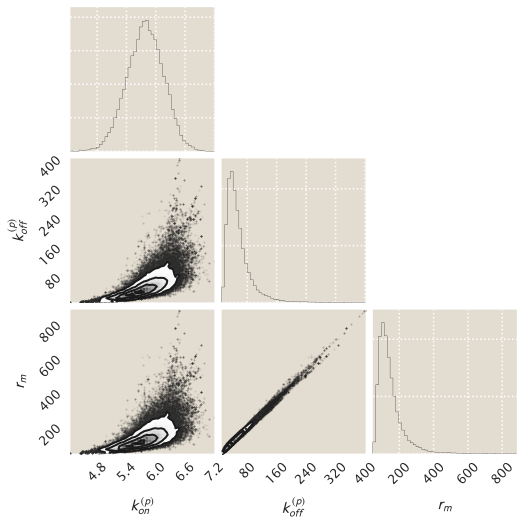

In [9]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()


# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
                   labels=[r'$k^{(p)}_{on}$', r'$k^{(p)}_{off}$', r'$r_m$'])
plt.savefig(figdir + 'lacUV5_mRNA_prior_corner_plot.png', bbox_inches='tight')

For convenience let's conver the chain into a `pandas` DataFrame.

In [10]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns
df_mcmc.head()

kp_on      kp_off          rm
0  6.049235  131.095861  315.977438
1  6.049235  131.095861  315.977438
2  6.053369  132.711373  319.550064
3  6.053369  132.711373  319.550064
4  6.053369  132.711373  319.550064

Now we can find the most likely parameter and the hpd.

In [11]:
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kpon, kpoff, rm = df_mcmc.iloc[max_idx, :]

# ea range
kpon_hpd = chann_cap.hpd(df_mcmc.iloc[:, 0], 0.95)
kpoff_hpd = chann_cap.hpd(df_mcmc.iloc[:, 1], 0.95)
rm_hpd = chann_cap.hpd(df_mcmc.iloc[:, 2], 0.95)

# Print results
print("""
The most probable parameters for the model
------------------------------------------
kp_on = {0:.1f} -{1:0.1f} +{2:0.1f}
kp_off = {3:.1f} -{4:0.1f} +{5:0.1f}
rm = {6:.1f} -{7:0.1f} +{8:0.1f}
""".format(kpon, np.abs(kpon-kpon_hpd[0]), np.abs(kpon-kpon_hpd[1]),\
           kpoff, np.abs(kpoff-kpoff_hpd[0]), np.abs(kpoff-kpoff_hpd[1]),\
           rm, np.abs(rm-rm_hpd[0]), np.abs(rm-rm_hpd[1])))


The most probable parameters for the model
------------------------------------------
kp_on = 5.5 -0.4 +1.0
kp_off = 28.9 -14.3 +93.0
rm = 87.6 -32.6 +197.8



Seems that there is a very strong correlation between the $\kpoff$ and the $\rm$ parameter. But the peak seems to be at values $\ll$ 1000. Let's re-do the sampling limiting the range.

Having defined this function let's compare the theoretical prediction with the experimental data!

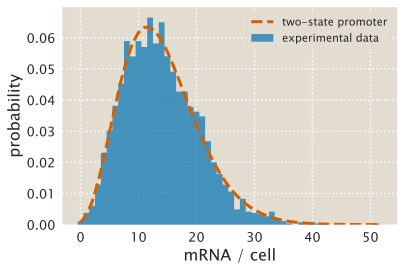

In [62]:
# Define bins
bins = np.arange(0, dfUV5.spots_totals.max())

logp_mRNA = log_p_m_unreg(bins, kpon, kpoff, 1, rm)

# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=bins, normed=1, histtype='stepfilled',
             alpha=0.7, label='experimental data', align='left')

plt.plot(bins, np.exp(logp_mRNA), color='r', ls='--', lw=3,# drawstyle='steps',
         label='two-state promoter')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.legend()
plt.savefig(figdir + 'lacUV5_two_state_mcmc_fit.png')

Let's now look at the CDF.

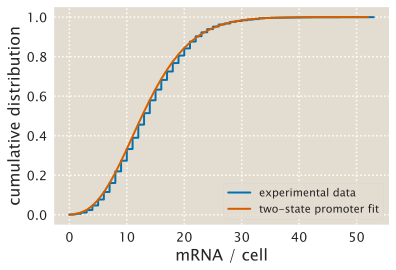

In [63]:
# Compute the empirical CDF
x, y = chann_cap.ecdf(dfUV5.spots_totals.values)
# Compute the theoretical CDF
cdf = np.cumsum(np.exp(logp_mRNA))

plt.plot(x, y, label='experimental data')
plt.plot(bins, cdf, color='r', ls='-', label='two-state promoter fit')
#          drawstyle='steps')

plt.xlabel('mRNA / cell')
plt.ylabel('cumulative distribution')
plt.legend()
plt.savefig(figdir + 'lacUV5_two_state_CDF_mcmc_fit.png')

The agreement between theory and data seems to be very promising!
That means that the parameters inferred could be potentially meaningful.

**Note:** An issue with these parameter values is that $\rm > \kpoff$. That means that the binding and unbinding of the RNAP is not in quasi-equilibrium with respect to the transcription initiaion.

## Accounting for variability in the number of promoters.

Jones et al. claim that the contribution to the noise in gene expression can be partially explained by the variability in gene copy number. For the locus in which our reporter construct is located (*galK*) we expect to have ≈ 1.66 copies of the gene. This implies that the cells spend **2/3** of the cell cycle with **two copies** of the promoter and the rest with a single copy.

Since for this data there is no labeling of the locus Jones et al. used area as a proxy for stage in the cell cycle. Following their procedure we will find the area threshold that sorts cells between having one or two copies of the promoter.

Let's plot the ECDF of the area and find the area value that separates the fractions of the cells.

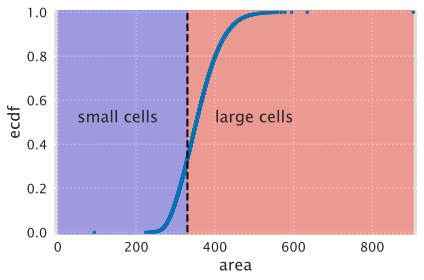

In [12]:
# Compute the area ECDF
x, y = chann_cap.ecdf(df['area_cells'])

# Find the value that is closest to 0.66
fraction = 1 / 3
idx = (np.abs(y - fraction)).argmin()
threshold = x[idx]

# Plot this ECDF
plt.plot(x[::20], y[::20], lw=0, marker='.')
# Plot vertical line next to the threshold
plt.plot([threshold, threshold], [0, 1], color='black', linestyle='--')

# Fill the area for small and large cells
plt.axvspan(0, threshold, alpha=0.3, color='blue')
plt.axvspan(threshold, max(x[::20]), alpha=0.3, color='red')

# Label as small and large cells
plt.text(50, 0.5, 'small cells', fontsize=16)
plt.text(400, 0.5, 'large cells', fontsize=16)

# Label plot
plt.xlabel('area')
plt.ylabel('ecdf')
plt.margins(0.01)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'area_division.pdf', bbox_inches='tight')

### Defining the log posterior probability

Having split the cells into small and large cells we can again use Bayes theorem to fit the parameters. Just as before given that we want to infer three parameters, $\kpon$, $\kpoff$ and $\rm$ we can write Bayes theorem as
$$
P(\mathbf{p} \mid D) = {P(D \mid \mathbf{p}) P(\mathbf{p})
\over P(D)},
$$
where $\mathbf{p} = (\kpon, \kpoff, \rm)$, and $D$ is the data. In this case we can split the data $D$ into two groups $D_1$ for cells with 1 copy of the promoter and $D_2$ for cells with two promoters. If we assume that each datum is independent we have for the likelihood $P(D \mid \mathbf{p})$ that
$$
P(D \mid \mathbf{p}) = \prod_{m \in D_1} P(m \mid \mathbf{p_1}) \cdot
\prod_{m \in D_2} P(m \mid \mathbf{p_2}),
$$
where $\mathbf{p_1} = (\kpon, \kpoff, \rm)$ are the parameters for the single copy cell and $\mathbf{p_2} = (\kpon, \kpoff, 2\rm)$ are the parametres for cells with two copies. We obviously assume that the only difference between the single and double promoter cells is that the production rate duplicates for cells with two promoters.

Using the same priors as for the single-promoter case let's define the log posterior probability.

In [13]:
def log_likelihood_double(params, data):
    """
    Log likelihood for the mRNA two-state distribution.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    data : 
        data[0] : array-like. n x 2
        data[0][:, 0] = unique mRNA counts for small cells
        data[0][:, 1] = frequency of each mRNA count for small cells
        data[1] : array-like. n x 2
        data[1][:, 0] = unique mRNA counts for large cells
        data[1][:, 1] = frequency of each mRNA count for large cells
    
    NOTE: The likelihood asks for unique mRNA entries and their corresponding 
    counts to speed up the process of computing the probability distribution. 
    Instead of computing the probability of 3 mRNAs n times, it computes it 
    once and multiplies the value by n.
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    # Unpack data
    mRNA_small, counts_small = data[0][:, 0], data[0][:, 1]
    mRNA_large, counts_large = data[1][:, 0], data[1][:, 1]
    
    return np.sum(counts_small * log_p_m_unreg(mRNA_small, kp_on, kp_off, 1, rm))\
    + np.sum(counts_large * log_p_m_unreg(mRNA_large, kp_on, kp_off, 1, 2 * rm))

def log_prior_double(params, pmax, thermo):
    """
    Log prior for kinetic parameters.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    pmax : array-like. 3 x 1.
        maximum value for the parameters given in the same order as params
    thermo : array-like. 2 x 1.
        thermo[0] = mean value for the thermodynamic constraint
        thermo[1] = variance for the thermodynamic constraint
        
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    kp_on_max, kp_off_max, rm_max = pmax
    
    # Define uniform priors for parameters
    if np.any(params < 1E-7):
        return -np.inf
    
    if kp_on > kp_on_max or kp_off > kp_off_max or rm > rm_max:
        return -np.inf

    return - (np.log(kp_on / kp_off) - thermo[0])**2 / 2 / thermo[1]**2


def log_posterior_double(params, data, pmax, thermo, log_sampling=False):
    """
    Log posterior
    """
    # Boolean logic to sample in linear or in log scale
    if log_sampling:
        params = 10**params
        
    # Compute log prior
    lp = log_prior_double(params, pmax, thermo)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood_double(params, data)

Let's now set the MCMC.

In [14]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 30
n_burn = 500
n_steps = 5000

# Splot DataFrame by area
dfUV5_small = dfUV5[dfUV5['area_cells'] < threshold]
# generate counts of each of the mRNA values
counts = dfUV5_small.spots_totals.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data_small = np.vstack([counts.index.values, counts.values]).T

# Splot DataFrame by area
dfUV5_large = dfUV5[dfUV5['area_cells'] > threshold]
# generate counts of each of the mRNA values
counts = dfUV5_large.spots_totals.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data_large = np.vstack([counts.index.values, counts.values]).T

# Join data sets
data = (data_small, data_large)


# Define parameter maximum values
pmax = [5000, 5000, 5000]
# Define thermodynamic constraint
p = 6 + np.log(2000 / 4.6E6)
thermo = [p, 0.3 * p]

# Initialize walkers
p0 = np.zeros([n_walkers, n_dim])
# Initialize kpon
p0[:, 0] = np.random.uniform(1E-5, 10, n_walkers)
# Initialize kpoff close to the ratio
p0[:, 1] = p0[:, 0] / np.exp(p)
# initialize rm
p0[:, 2] = np.random.uniform(10, 100, n_walkers)


# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_double,\
            args=(data, pmax, thermo),\
            threads=6)

Now we can run it!

In [15]:
sample = False
if sample:
    #Do the burn in 
    print('performing burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('performing MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'wb')
    print('done!')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)
    output.close() # close it to make sure it's all been written

Having finished the sampling let's load the chains and plot the corner-plot.

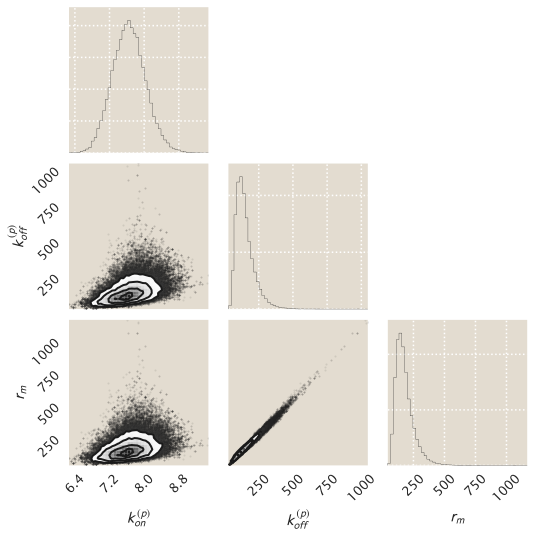

In [66]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()


# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
                   labels=[r'$k^{(p)}_{on}$', r'$k^{(p)}_{off}$', r'$r_m$'])
plt.tight_layout()
plt.savefig(figdir + 'lacUV5_mRNA_double_corner_plot.png', bbox_inches='tight')

There is a single peak again. Let's transform the chain in to a DataFrame.

In [16]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns
df_mcmc.head()

kp_on     kp_off          rm
0  7.467328  79.738228  101.110103
1  7.467328  79.738228  101.110103
2  7.467328  79.738228  101.110103
3  7.450984  91.924368  116.037133
4  7.547807  68.479526   87.531944

Now let's find the most likely parameter along with the hpd.

In [17]:
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kpon_double, kpoff_double, rm_double = df_mcmc.iloc[max_idx, :]

# ea range
kpon_hpd = chann_cap.hpd(df_mcmc.iloc[:, 0], 0.95)
kpoff_hpd = chann_cap.hpd(df_mcmc.iloc[:, 1], 0.95)
rm_hpd = chann_cap.hpd(df_mcmc.iloc[:, 2], 0.95)

# Print results
print("""
The most probable parameters for the model
------------------------------------------
kp_on = {0:.1f} -{1:0.1f} +{2:0.1f}
kp_off = {3:.1f} -{4:0.1f} +{5:0.1f}
rm = {6:.1f} -{7:0.1f} +{8:0.1f}
""".format(kpon_double, np.abs(kpon_double-kpon_hpd[0]), 
           np.abs(kpon_double-kpon_hpd[1]),
           kpoff_double, np.abs(kpoff_double-kpoff_hpd[0]), 
           np.abs(kpoff_double-kpoff_hpd[1]),\
           rm_double, np.abs(rm_double-rm_hpd[0]), np.abs(rm_double-rm_hpd[1])))


The most probable parameters for the model
------------------------------------------
kp_on = 7.5 -0.6 +0.9
kp_off = 93.7 -43.7 +193.0
rm = 117.7 -49.9 +204.1



Let's plot both fits, the single and double promoter.

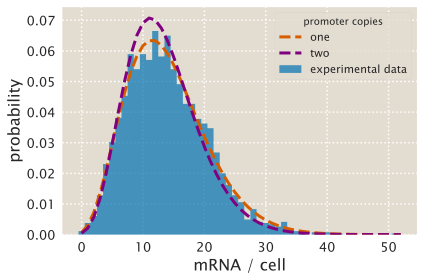

In [77]:
# Define bins
bins = np.arange(0, dfUV5.spots_totals.max())

# Compute the probability using a one-copy promoter
logp_mRNA = log_p_m_unreg(bins, kpon, kpoff, 1, rm)

# Compute the probability using a two-copy promoter
fraction = 1 / 3
logp_mRNA_double = fraction * log_p_m_unreg(bins, kpon_double, 
                                            kpoff_double, 1, rm_double)\
                +  (1 - fraction) * log_p_m_unreg(bins, kpon_double, kpoff_double, 
                                                  1, 2 * rm_double)
# Re-Normalize distribution
logp_mRNA_double = logp_mRNA_double - scipy.special.logsumexp(logp_mRNA_double)

# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=bins, normed=1, histtype='stepfilled',
             alpha=0.7, label='experimental data', align='left')

plt.plot(bins, np.exp(logp_mRNA), 
         color='r', ls='--', lw=3,
         label='one')
plt.plot(bins, np.exp(logp_mRNA_double), 
         color='purple', ls='--', lw=3,
         label='two')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.legend(title='promoter copies')

plt.tight_layout()
plt.savefig(figdir + 'lacUV5_two_state_mcmc_multi_copy.pdf',
            bbox_inches='tight')

## Extending fitting procedure to all promoters.
---
### Incomplete...
---


Let's extend this procedure to all of the promoters in the data-set.

First let's look at all the promoters that do not contain the string `ngmL` in their name since these are regulated promoters.

In [ ]:
# Define data frame without the experiments with induction
df_unreg = df[['ngmL' not in x for x in df.experiment]]

# Generate list of promoters by increasing mean mRNA copy number
promoters = df_unreg.groupby('experiment').mean().spots_totals.sort_values().index

# Generate a dictionary with the colors to be used in the plot
colors = sns.color_palette('Blues', n_colors=len(promoters))
color_dict = dict(zip(promoters, colors))

# Loop through different promoters
for prom in promoters:
    # Extract the promoter data
    data = df_unreg[df_unreg.experiment == prom]
    # Compute the empirical CDF
    x, y = chann_cap.ecdf(data.spots_totals.values)
    # Plot the ECDF
    plt.plot(x, y, label=prom, color=color_dict[prom])

# Label plot
plt.xlabel('mRNA / cell')
plt.ylabel('cumulative distribution')
plt.legend(fontsize=8, ncol=2)

Let's now perform the parameter estimate for this data. We will store all of the parameters into a tidy `DataFrame`.

In [ ]:
# Group data by experiment
df_group = df_unreg.groupby('experiment')

# List the variabes to be saved in the DataFrame.
var = ['experiment', 'mean_mRNA', 'n_cells',
       'kp_on', 'kp_off', 'rm', 'gm']
# Initialize Data Frame to save rates
df_param = pd.DataFrame(columns=var)

# Loop through promotres
for group, data in df_group:
    # Extract data to compute moments
    mRNA = data.spots_totals.values
    N = len(mRNA)

    # 1. Compute the moments estimators
    m_first = 1 / N * np.sum(mRNA)
    m_second = 1 / N * np.sum(mRNA * (mRNA - 1))
    m_third = 1 / N * np.sum(mRNA * (mRNA - 1) * (mRNA - 2))

    # 2. Compute moment ratios
    r1 = m_first
    r2 = m_second / m_first
    r3 = m_third / m_second

    # 3. Compute parameters
    kon = 2 * r1 * (r3 - r2) / (r1 * r2 - 2 * r1 * r3 + r2 * r3)
    koff = 2 * (r2 - r1) * (r1 - r3) * (r3 - r2) / \
               ((r1 * r2 - 2 * r1 * r3 + r2 * r3) * (r1 - 2 * r2 + r3))
    rm = (- r1 * r2 + 2 * r1 * r3 - r2 * r3) / \
             (r1 - 2 * r2 + r3)

    # 4. Compute the values knowing the gamma_m value
    gamma_m = 0.00284
    kon = kon * gamma_m
    koff = koff * gamma_m
    rm = rm * gamma_m

    # 5. Append results into data frame
    param = pd.Series([group, data.spots_totals.mean(), len(data),
                       kon, koff, rm, gamma_m], index=var)
    df_param = df_param.append(param, ignore_index=True)

In [ ]:
df_param.sort_values('mean_mRNA')

Let's plot the promoters that do not have negative parameter values and save them into a multi-page PDF document

In [ ]:
with PdfPages(figdir + 'unreg_promoter_fits_PMF.pdf') as pdf:
    for prom in promoters:
        # Extract parameters from this specific promoter
        par = df_param[df_param.experiment == prom][['kp_on', 'kp_off', 
                                                         'rm', 'gm']]
        # Check if all parameters have positive values
        if np.any(par < 0):
            continue
            
        # Convert parameters into dictionary
        par = par.to_dict(orient='records')[0]
        # Extract data from promoter
        df_plot = df[df.experiment == prom]

        # Define bins
        bins = np.arange(0, df_plot.spots_totals.max())

        # Comput theoretical PMF
        logp_mRNA = log_p_m_unreg(bins, **par)

        # Plot the histogram of the data with bins of width 1
        _ = plt.hist(df_plot.spots_totals, bins=bins, normed=1,
                     histtype='stepfilled', alpha=0.7,
                     label='experimental data', align='left')

        # Plot theoretical pdf
        plt.plot(bins, np.exp(logp_mRNA), color='r', ls='--', lw=3,
                 label='two-state promoter')

        # Label the plot
        plt.xlabel('mRNA / cell')
        plt.ylabel('probability')
        title = r'{0:s} $\left\langle m \right\rangle$: {1:.1f}'.format(prom, 
                df_param[df_param.experiment == prom].mean_mRNA.values[0])
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

In [ ]:
with PdfPages(figdir + 'unreg_promoter_fits_CDF.pdf') as pdf:
    for prom in promoters:
        # Extract parameters from this specific promoter
        par = df_param[df_param.experiment == prom][['kp_on', 'kp_off', 
                                                         'rm', 'gm']]
        # Check if all parameters have positive values
        if np.any(par < 0):
            continue
            
        # Convert parameters into dictionary
        par = par.to_dict(orient='records')[0]
        # Extract data from promoter
        df_plot = df[df.experiment == prom]

        # Define bins
        bins = np.arange(0, df_plot.spots_totals.max())

        # Comput theoretical PMF
        logp_mRNA = log_p_m_unreg(bins, **par)
        # Compute the theoretical CDF
        cdf = np.cumsum(np.exp(logp_mRNA))
        
        # Compute the empirical CDF
        x, y = chann_cap.ecdf(df_plot.spots_totals.values)
        
        # Plot both CDFs
        plt.plot(x, y, label='experimental data')
        plt.plot(bins, cdf, color='r', ls='-', label='two-state promoter fit')

        # Label the plot
        plt.xlabel('mRNA / cell')
        plt.ylabel('probability')
        title = r'{0:s} $\left\langle m \right\rangle$: {1:.1f}'.format(prom, 
                df_param[df_param.experiment == prom].mean_mRNA.values[0])
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

## Regulated promoters.

Among this data set Jones and Brewster have regulated promoters in which the *lac* repressor controls the expression of the promoter. For this particular experiment Jones & Brewster didn't use the strains from Garcia & Phillips, 2011 where the mean repressor copy number was known for a specific ribosomal binding site sequence. Instead they used a construct in which the repressor copy number could be controled itself via aTc induction.

Let's look at this specific data sets.

In [3]:
# Define name of operators
operators = ['O1', 'O2', 'O3', 'Oid']

# Extract the experiments that contain any 'ngmL' string and one of the operators
rep_exp = [x for x in df['experiment'].unique() if 'ngmL' in x and
           any(op in x for op in operators)]

# Initialize Data Frame to save the regulated data sets
names = ['area_cells', 'date', 'experiment', 'spots_totals',
         'operator', 'atc_ngmL']
df_reg = pd.DataFrame(columns=names)

# Loop through each of the experiments
for exp in rep_exp:
    # Split experiment name to extract operator
    op, concentration = exp.split('_')
    
    # Extract concentration
    concentration = concentration.replace('ngmL', '')
    # Change xpy for x.y
    if 'p' in concentration:
        concentration = float('.'.join(concentration.split('p')))
    # Else convert to float
    else:
        concentration = float(concentration)
        
    # Extract experiment data
    data = df[df['experiment'] == exp]
    
    # Add operator and atc concentration to data set
    data.loc[:, 'operator'] = pd.Series([op] * len(data), index=data.index)
    data.loc[:, 'atc_ngmL'] = pd.Series([concentration] * len(data),
                                        index=data.index)
    
    # Append to Data Frame
    df_reg = df_reg.append(data, ignore_index=True)

# Write down this data into a file.
df_reg.to_csv('../../data/mRNA_FISH/Jones_Brewster_regulated_2014.csv', 
              index=False)
df_reg.head()

/Users/razo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/razo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


area_cells      date  experiment spots_totals operator  atc_ngmL
0        418  20131101  O1_0p5ngmL           15       O1       0.5
1        389  20131101  O1_0p5ngmL            3       O1       0.5
2        434  20131101  O1_0p5ngmL           11       O1       0.5
3        373  20131101  O1_0p5ngmL           12       O1       0.5
4        345  20131101  O1_0p5ngmL            9       O1       0.5

Having extracted the data, let's plot the distributions and save them into a multi-page PDF.

In [5]:
# Group data by experiment
df_group = df_reg.groupby(['operator', 'atc_ngmL'])

# Initialize multipage PDF
with PdfPages(figdir + 'reg_promoter_PMF.pdf') as pdf:
    for (op, atc), data in df_group:
        fig = plt.figure(figsize=(5, 5))
        # Plot the histogram of the data with bins of width 1
        _ = plt.hist(data.spots_totals, 
                     bins=np.arange(0, data.spots_totals.max()),
                     normed=1, histtype='stepfilled', align='left')

        # Label the plot
        plt.xlabel('mRNA / cell')
        plt.ylabel('probability')
        title = r'{0:s} [atc] = {1:.1f} ng/mL'.format(op, atc)
        plt.title(title)
        plt.tight_layout()
        pdf.savefig()
        plt.close()

Let's also plot all the PMFs and CDFs per operator.

In [26]:
# Group data set by operator
df_op = df_reg.groupby('operator')

# Initialize multipage PDF plot
with PdfPages(figdir + 'reg_promoter_PMF_CDF.pdf') as pdf:
    # Loop through operator groups
    for group, data in df_op:
        # Group by concentration
        df_group = data.groupby('atc_ngmL')

        # extract different aTc concentrations
        atc_array = list(df_group.groups.keys())

        # indicate bins
        x = np.arange(data['spots_totals'].max() + 1)

        # Initialize array to save distributions
        px = np.zeros([len(atc_array), len(x)])

        # Loop through each group and save probability
        for i, (g, d) in enumerate(df_group):
            prob = d.spots_totals.value_counts(normalize=True, sort=False) 
            px[i, prob.index] = prob.values

        chann_cap.pmf_cdf_plot(x, px, atc_array, figsize=(7, 6),
                               xlabel='mRNA / cell', title=group,
                               ylim=[0, np.max(px) * 1.2], 
                               cbar_label='[aTc] ng/mL')
        
        pdf.savefig(bbox_inches='tight')
        plt.close()

/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Let's use the powerful `pandas` features to describe all of these data sets.

In [81]:
# Group by operator, and atc concentration. Extract the spots_totals column,
# convert to integers and print the rounded description of this data
# all in a single command!
df_reg['spots_totals'].astype('int').groupby([df_reg['operator'],
                                              df_reg['atc_ngmL']]).describe()\
                                                                  .round(1)  

count  mean   std  min   25%   50%   75%    max
operator atc_ngmL                                                  
O1       0.5       2070.0  24.4  16.2  0.0  12.0  21.0  34.0  110.0
         1.0        857.0   3.9   5.3  0.0   0.0   2.0   5.0   54.0
         2.0        419.0   0.9   1.9  0.0   0.0   0.0   1.0   15.0
         10.0      1454.0   0.6   1.2  0.0   0.0   0.0   1.0    8.0
O2       0.5        594.0  21.5  13.4  0.0  11.0  19.0  28.8   80.0
         1.0        884.0  10.2   9.1  0.0   4.0   8.0  13.2   67.0
         2.0        336.0   3.7   4.3  0.0   0.0   2.0   6.0   30.0
         10.0      1191.0   1.4   2.2  0.0   0.0   0.0   2.0   20.0
O3       0.5       1521.0  22.2  13.3  0.0  13.0  20.0  29.0  103.0
         1.0        559.0  24.1  13.7  0.0  14.0  22.0  32.0   77.0
         2.0        438.0  22.9  13.4  0.0  13.0  20.0  30.0   69.0
         10.0       811.0  22.1  13.0  0.0  12.0  19.0  30.0   75.0
Oid      0.5        719.0  21.9  16.9  0.0   9.0  19.0  30.0  103.0
         1.0        386.0   2.1   4.7  0.0   0.0   0.0   2.0   33.0
         2.0        756.0   0.2   0.8  0.0   0.0   0.0   0.0   10.0
         10.0       949.0   0.3   1.1  0.0   0.0   0.0   0.0   22.0

There is a very weird hidden feature about this data. Let's take a look at the mean mRNA/cell for the lowest aTc induction level, i.e. the one with the least repressor copy number:

In [126]:
print('0.5 ng/mL aTc <m> = ',
      round(df_reg[df_reg['atc_ngmL'] == 0.5].spots_totals.mean()))

0.5 ng/mL aTc <m> =  23.0


Jones & Brewster reported in their publication that all these measurements were made using the lacUV5 promoter. This promoter itself was also measured in the complete absence of the repressor and as shown before the mean is far from this. Let's look at this mean:

In [127]:
print('lacUV5 <m> = ',
      round(df[df['experiment'] == 'UV5'].spots_totals.mean(), 1))

lacUV5 <m> =  13.9


This is definitely lower than the one with a regulated case. On a personal communication I talked with Robert Brewster and here is what he had to say about this difference:
> It’s all LacUV5. I’m trying to think of a reason that the regulation strains would be different. They do have different genetic perturbations. The constitutive ones just have the LacZ construct in Galk where as the regulated ones have 1147 LacI in YBCN AND the TetR construct in gspI. Perhaps all those changes are simply changing the fundamental level of expression by changing the physiology a little bit, I’m not sure… Or even perhaps ATC changes the cell a little. This doesn’t have to do with something weird like bad calibration factors? Or dividing by average gene copy number in one but not the other, right? The reporter constructs should be exactly the same. I think I even made them in the same pass from the same HG105 strain. 
-- Brewster, personal communication 2018-04-26.

### aTc induction experiments

The data set provided by Brewster contains experiments in which no operator is specified (unfortunate data handling), but an aTc concentration is listed. Let's take a look at this data.

In [113]:
# Define name of operators
operators = ['O1', 'O2', 'O3', 'Oid']

# Extract the experiments that contain any 'ngmL' string and one of the operators
no_op_exp = [x for x in df['experiment'].unique() if 'ngmL' in x and
             all(op not in x for op in operators)]

# Initialize Data Frame to save the regulated data sets
names = ['area_cells', 'date', 'experiment', 'spots_totals', 'atc_ngmL']
df_no_op = pd.DataFrame(columns=names)

# Loop through each of the experiments
for exp in no_op_exp:
    # Extract concentration
    concentration = exp.replace('ngmL', '')
    # Change xpy for x.y
    if 'p' in concentration:
        concentration = float('.'.join(concentration.split('p')))
    # Else convert to float
    else:
        concentration = float(concentration)
        
    # Extract experiment data
    data = df[df['experiment'] == exp]
    
    # Add operator and atc concentration to data set
    data.loc[:, 'atc_ngmL'] = pd.Series([concentration] * len(data),
                                        index=data.index)
    
    # Append to Data Frame
    df_no_op = df_no_op.append(data, ignore_index=True)

df_no_op.head()

/Users/razo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/razo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


area_cells      date experiment spots_totals  atc_ngmL
0        464  20130921      0ngmL           14       0.0
1        330  20130921      0ngmL           18       0.0
2        375  20130921      0ngmL            6       0.0
3        453  20130921      0ngmL           28       0.0
4        361  20130921      0ngmL            9       0.0

We will plot this data into a multipage PDF file to look at the distributions.

In [83]:
# Group data by experiment
df_group = df_no_op.groupby(['atc_ngmL'])

with PdfPages(figdir + 'no_op_promoter_PMF.pdf') as pdf:
    for atc, data in df_group:
        fig = plt.figure(figsize=(5, 5))
        # Plot the histogram of the data with bins of width 1
        _ = plt.hist(data.spots_totals, 
                     bins=np.arange(0, data.spots_totals.max()),
                     normed=1, histtype='stepfilled', align='left')

        # Label the plot
        plt.xlabel('mRNA / cell')
        plt.ylabel('probability')
        title = r'[atc] = {:.1f} ng/mL'.format(atc)
        plt.title(title)
        plt.tight_layout()
        pdf.savefig()
        plt.close()

Let's now list the summary description of the data set.

In [114]:
# Group by operator, and atc concentration. Extract the spots_totals column,
# convert to integers and print the rounded description of this data
# all in a single command!
df_no_op['spots_totals'].astype('int').groupby(df_no_op['atc_ngmL']).describe()\
                                                                    .round(1)  

count  mean  std  min  25%   50%   75%   max
atc_ngmL                                               
0.00      3611.0  13.9  9.2  0.0  7.0  12.0  19.0  75.0
0.25      3071.0  13.5  9.0  0.0  7.0  12.0  18.0  66.0
0.50      3609.0   9.1  8.4  0.0  3.0   7.0  13.0  78.0
0.75      1350.0   2.1  3.8  0.0  0.0   0.0   3.0  28.0
1.00      3037.0   2.4  4.2  0.0  0.0   1.0   3.0  40.0
1.25      3005.0   0.6  1.6  0.0  0.0   0.0   1.0  28.0
1.50      3363.0   0.4  1.3  0.0  0.0   0.0   0.0  29.0
2.00      3209.0   0.2  0.6  0.0  0.0   0.0   0.0   6.0
10.00     2895.0   0.1  0.5  0.0  0.0   0.0   0.0  11.0

This is very interesting. at the 0 ng/mL aTc concentration we see that the promoter has **the exact same mean** as in the unregulated case. Let's specifically look at these two data sets.

In [118]:
# Extract the lacUV5 data and the data at 0ng/mL aTc for comparison
df[(df.experiment == '0ngmL') |
   (df.experiment == 'UV5')]['spots_totals'].astype('int').\
                            groupby(df['experiment']).describe().round(1) 

count  mean  std  min  25%   50%   75%   max
experiment                                               
0ngmL       3611.0  13.9  9.2  0.0  7.0  12.0  19.0  75.0
UV5         2648.0  13.9  6.5  0.0  9.0  13.0  18.0  53.0

Let's compare both distributions by plotting the PMF and CDF together.

/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


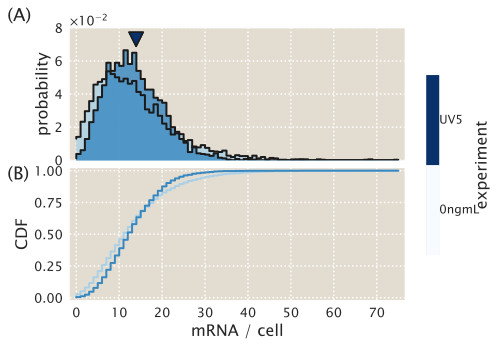

In [33]:
# Extract the two experiments to be compared and 
df_comp = df[(df.experiment == '0ngmL') | (df.experiment == 'UV5')]

# Group them by experiment
df_group = df_comp.groupby('experiment')

# extract different experients concentrations
exps = list(df_group.groups.keys())

# indicate bins
x = np.arange(df_comp['spots_totals'].max() + 1)

# Initialize array to save distributions
px = np.zeros([len(exps), len(x)])

# Loop through each group and save probability
for i, (group, data) in enumerate(df_group):
    prob = data.spots_totals.value_counts(normalize=True, sort=False) 
    px[i, prob.index] = prob.values

chann_cap.pmf_cdf_plot(x, px, exps, xlabel='mRNA / cell',
                       ylim=[0, np.max(px) * 1.2], 
                       cbar_label='experiment')

They do look pretty similar.

/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


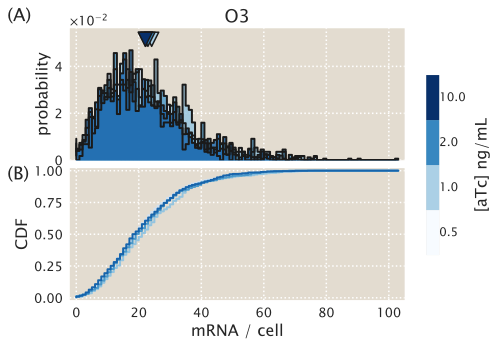

In [27]:
# Extract data from an operator
df_op = df_reg[df_reg.operator == 'O3']

# Group by concentration
df_group = df_op.groupby('atc_ngmL')

# extract different aTc concentrations
atc_array = list(df_group.groups.keys())

# indicate bins
x = np.arange(df_op['spots_totals'].max() + 1)

# Initialize array to save distributions
px = np.zeros([len(atc_array), len(x)])

# Loop through each group and save probability
for i, (group, data) in enumerate(df_group):
    prob = data.spots_totals.value_counts(normalize=True, sort=False) 
    px[i, prob.index] = prob.values

chann_cap.pmf_cdf_plot(x, px, atc_array, xlabel='mRNA / cell', title='O3',
                               ylim=[0, np.max(px) * 1.2], 
                               cbar_label='[aTc] ng/mL')